# IBM's Superconducting Quantum Computer Model

## 1. Setup and Dependencies

<div style="background-color: #e8f8f0; padding: 15px; border-left: 5px solid #27ae60; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.05); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; word-wrap: break-word; box-sizing: border-box;">

  <h2 style="color: #2c3e50;">Environment Setup</h2>

  <p style="font-size: 14px; color: #34495e;">
    Install required libraries and set up the environment for quantum simulations using IBM's quantum superconducting architecture noise model.
  </p>

</div>

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb 

# Save your IBM Quantum account (run this once)
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="GIt-Hr7Vo-5ok2DRPm3P1zUam5g84UfiS5BI_vYF3bDe",
    overwrite=True
)

# Styling for plots
sns.set()

## 2. Quantum Galton Board

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Quantum Galton Board (n-layer, Base Noisy)</h2>
  <p>
    We model a n-layer Quantum Galton Board using (2 * layer + 1) + 1 qubits to approximate a binomial distribution, simulating it with IBM's ibm_brisbane back end. This section shows the base noisy circuit without optimization.
  </p>
</div>

In [15]:
def create_galton_board(layers):
    # classical information 
    bins = layers + 1

    # quantum circuit set up
    n_qubits = (2 * layers + 1) + 1
    n_bits = bins

    qc = QuantumCircuit(n_qubits, n_bits)

    # define useful concepts
    ancilla = 0
    ball = bins

    state_0 = [1, 0]

    def pegs(layer, qc):
        if layer != 1:
            qc.initialize(state_0, ancilla)
            qc.h(ancilla)
        else:
            qc.h(ancilla)
            qc.x(ball)
        
        for j in range(0, (2 * layer - 1)):
            base = ball - layer + j
            qc.cswap(ancilla, base, base + 1)
            qc.cx(base + 1, ancilla)
        
        base = ball + layer
        qc.cswap(ancilla, base - 1, base)

    i = 1
    while i <= layers:
        pegs(i, qc)
        i += 1

    # Measuring the qubits
    for i in range(bins):
        qc.measure((2 * i + 1), i)

    return qc

In [ ]:
# Create circuit for 5 layers
layers = 5
qc = create_galton_board(layers)

# Set up noise model from open-access IBM backend
try:
    service = QiskitRuntimeService(channel="ibm_quantum_platform")
    backend = service.backend("ibm_brisbane")  # 127 qubits, open-access
    if backend.configuration().n_qubits < 14:
        raise ValueError(f"{backend.name} has only {backend.configuration().n_qubits} qubits, need 14")
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from open-access IBM backend: {backend.name} ({backend.configuration().n_qubits} qubits)")
except Exception as e:
    print(f"Failed to access ibm_brisbane: {e}")
    print("Falling back to GenericBackendV2 with custom noise")
    from qiskit.providers.fake_provider import GenericBackendV2
    n_qubits = (2 * layers + 1) + 1
    backend = GenericBackendV2(
        num_qubits=n_qubits,
        basis_gates=['h', 'cx', 'swap', 'x'],
        coupling_map=[[i, i+1] for i in range(n_qubits-1)],
        gate_error_1q=0.001,
        gate_error_2q=0.01,
        t1=50e3,
        t2=50e3,
        gate_duration_1q=50,
        gate_duration_2q=200,
        readout_error=0.02
    )
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from GenericBackendV2 with {n_qubits} qubits")

# Transpile circuit for the backend (optimization_level=2 for better gate mapping)
transpiled_qc = transpile(qc, backend, optimization_level=1)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-09 05:16:02,549: Default instance not set. Searching all available instances.


Using noise model from open-access IBM backend: ibm_brisbane (127 qubits)


In [8]:
# Simulate with noise
simulator = AerSimulator(noise_model=noise_model)
shots = 1000
result = simulator.run(transpiled_qc, shots=shots).result()
counts = result.get_counts()

# Plot raw counts
plt.figure(figsize=(10, 6))
plot_histogram(counts, title=f"Quantum Galton Board ({layers} Layers, Noisy)")
plt.show()

<Figure size 1000x600 with 0 Axes>

Bin probabilities (bins 0 to 5): [0.018, 0.075, 0.126, 0.085, 0.038, 0.011]
Error probability: 0.6470000000000001
Sum of bin probabilities: 0.353
KL Divergence from Ideal Binomial: 1.0761790917644019


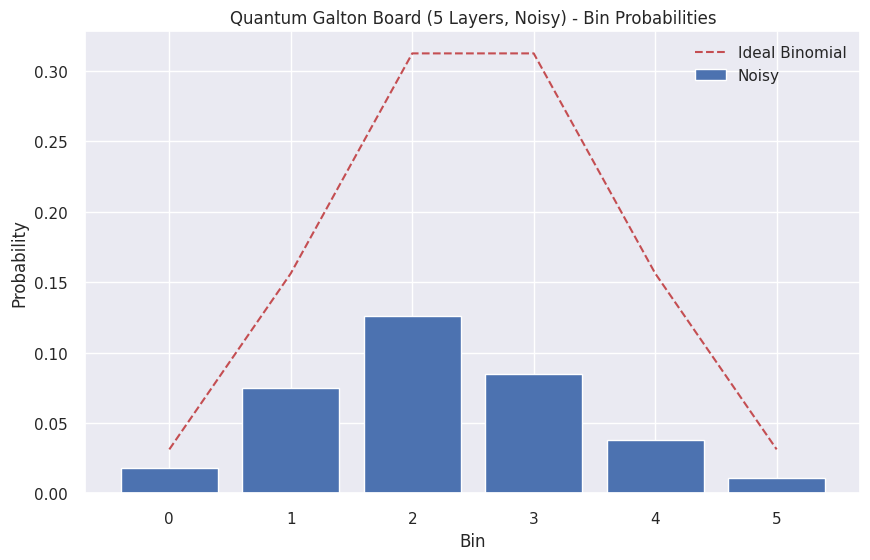

In [17]:
# Analyze probabilities
bins = layers + 1
bin_probs = np.zeros(bins)
error_prob = 0.0

for state, count in counts.items():
    if state.count('1') == 1:
        reversed_state = state[::-1]
        bin_index = reversed_state.index('1')
        bin_probs[bin_index] += count / shots
    else:
        error_prob += count / shots

# Theoretical binomial probabilities
p = 0.5  # Fair coin probability for Galton Board
k = np.arange(bins)
ideal_probs = np.array([comb(layers, i) * (p ** i) * ((1 - p) ** (layers - i)) for i in k])
ideal_probs /= ideal_probs.sum()  # Normalize

# KL divergence (add epsilon to avoid log(0))
epsilon = 1e-10
kl_divergence = np.sum(ideal_probs * np.log(ideal_probs / (bin_probs + epsilon)))

print(f"Bin probabilities (bins 0 to {bins-1}):", bin_probs.tolist())
print("Error probability:", error_prob)
print("Sum of bin probabilities:", np.sum(bin_probs))
print("KL Divergence from Ideal Binomial:", kl_divergence)

# Plot bin probabilities
plt.figure(figsize=(10, 6))
plt.bar(range(bins), bin_probs, label='Noisy')
plt.plot(range(bins), ideal_probs, 'r--', label='Ideal Binomial')
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title(f"Quantum Galton Board ({layers} Layers, Noisy) - Bin Probabilities")
plt.legend()
plt.show()

In [18]:
def create_exponential_galton_board(layers, lam):
    # classical information 
    bins = layers + 1

    # quantum circuit set up
    n_qubits = (2 * layers + 1) + 1
    n_bits = bins

    qc = QuantumCircuit(n_qubits, n_bits)

    # define useful concepts
    ancilla = 0
    ball = bins
    state_0 = [1, 0]

    def p(l, j, lam):
        s = np.exp(lam)
        return 1 - (s**(j + 1) - 1) / (s**(l + 2) - 1)

    def theta(l, j, lam):
        return 2 * np.arcsin((p(l, j, lam)) ** (1/2))

    for layer in range(layers):
        num_pegs = layer + 1
        for j in range(num_pegs):
            input_q = ball - layer + 2 * j
            left_q = input_q - 1
            right_q = input_q + 1
            if layer == 0 and j == 0:
                qc.rx(theta(layer, j, lam), ancilla)
                qc.x(input_q)
            else:
                qc.initialize(state_0, ancilla)
                qc.rx(theta(layer, j, lam), ancilla)
            # peg module
            qc.cswap(ancilla, left_q, input_q)
            qc.cx(input_q, ancilla)
            qc.cswap(ancilla, input_q, right_q)
            # corrective if j > 0
            if j > 0:
                qc.cx(input_q, left_q)
                qc.initialize(state_0, input_q)

    for i in range(bins):
        qc.measure(2 * i + 1, i)

    return qc

In [24]:
# Create circuit
layers = 4  # Example with 4 layers
lam = 1  # Example lambda value
qc = create_exponential_galton_board(layers, lam)

# Set up noise model from open-access IBM backend
try:
    service = QiskitRuntimeService(channel="ibm_quantum_platform")
    backend = service.backend("ibm_brisbane")  # 127 qubits, open-access
    if backend.configuration().n_qubits < 10:  # For 4 layers: 10 qubits
        raise ValueError(f"{backend.name} has only {backend.configuration().n_qubits} qubits, need at least 10")
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from open-access IBM backend: {backend.name} ({backend.configuration().n_qubits} qubits)")
except Exception as e:
    print(f"Failed to access ibm_brisbane: {e}")
    print("Falling back to GenericBackendV2 with custom noise")
    from qiskit.providers.fake_provider import GenericBackendV2
    n_qubits = (2 * layers + 1) + 1
    backend = GenericBackendV2(
        num_qubits=n_qubits,
        basis_gates=['rx', 'cx', 'swap', 'x'],
        coupling_map=[[i, i+1] for i in range(n_qubits-1)],
        gate_error_1q=0.001,
        gate_error_2q=0.01,
        t1=50e3,
        t2=50e3,
        gate_duration_1q=50,
        gate_duration_2q=200,
        readout_error=0.02
    )
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from GenericBackendV2 with {n_qubits} qubits")

# Transpile circuit
transpiled_qc = transpile(qc, backend, optimization_level=1)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-09 05:40:24,345: Default instance not set. Searching all available instances.


Using noise model from open-access IBM backend: ibm_brisbane (127 qubits)


In [25]:
# Simulate with noise
simulator = AerSimulator(noise_model=noise_model)
shots = 1000
result = simulator.run(transpiled_qc, shots=shots).result()
counts = result.get_counts()

# Plot raw counts
plt.figure(figsize=(10, 6))
plot_histogram(counts, title=f"Exponential Galton Board ({layers} Layers, Noisy)")
plt.show()

<Figure size 1000x600 with 0 Axes>

Bin probabilities (bins 0 to 4): [0.176, 0.11, 0.056, 0.029, 0.007]
Error probability: 0.6220000000000001
Sum of bin probabilities: 0.378
Quantum KL Divergence (vs Exponential): 0.0746


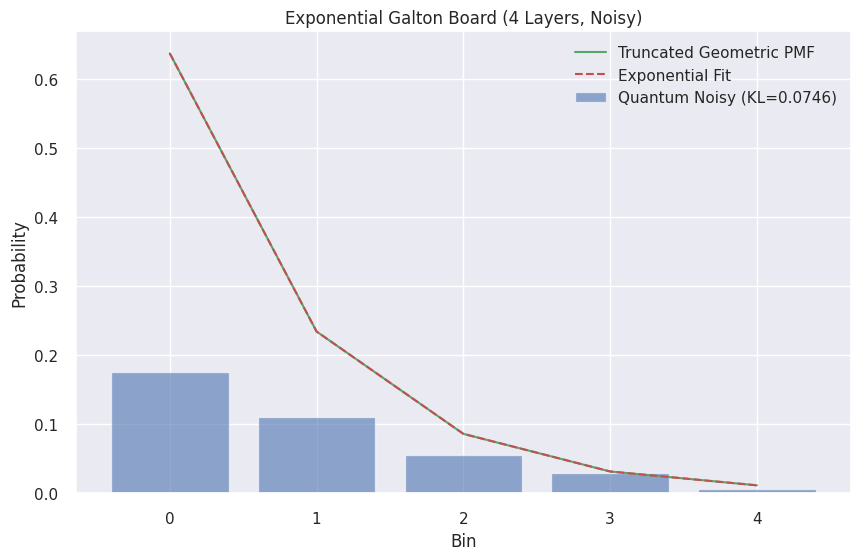

In [33]:
# Analyze probabilities
def p(l, j, lam):
    s = np.exp(lam)
    return 1 - (s**(j + 1) - 1) / (s**(l + 2) - 1)

def kl_div(p, q):
    eps = 1e-10
    p_adj = p + eps
    q_adj = q + eps
    p_adj /= p_adj.sum()
    q_adj /= q_adj.sum()
    return np.sum(p_adj * np.log(p_adj / q_adj))

bins = layers + 1
bin_probs = np.zeros(bins)
error_prob = 0.0

for state, count in counts.items():
    if state.count('1') == 1:
        reversed_state = state[::-1]
        bin_index = reversed_state.index('1')
        bin_probs[bin_index] += count / shots
    else:
        error_prob += count / shots

# Theoretical truncated geometric probabilities
r = np.exp(-lam)
norm_factor = 1 - r**(layers + 1)
x = np.arange(bins)
theo_probs = np.array([(1 - r) * r**k / norm_factor for k in x])

# Continuous exponential PDF (scaled)
exp_pdf = lam * np.exp(-lam * x)
exp_probs = exp_pdf / np.sum(exp_pdf)  # Normalize

# Compute KL divergence
quantum_kl = kl_div(bin_probs, exp_probs)

print(f"Bin probabilities (bins 0 to {bins-1}):", bin_probs.tolist())
print("Error probability:", error_prob)
print("Sum of bin probabilities:", np.sum(bin_probs))
print(f"Quantum KL Divergence (vs Exponential): {quantum_kl:.4f}")

# Plot bin probabilities
plt.figure(figsize=(10, 6))
plt.bar(x, bin_probs, alpha=0.6, label=f'Quantum Noisy (KL={quantum_kl:.4f})')
plt.plot(x, theo_probs, 'g-', label='Truncated Geometric PMF')
plt.plot(x, exp_probs, 'r--', label='Exponential Fit')
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title(f'Exponential Galton Board ({layers} Layers, Noisy)')
plt.legend()
plt.show()

In [2]:
# Hadamard Quantum Walk function
def hadamard_quantum_walk(num_steps, num_pos_qubits):
    total_qubits = num_pos_qubits + 1  # Position qubits + 1 coin qubit
    coin_qubit = num_pos_qubits
    pos_qubits = list(range(num_pos_qubits))

    # Define increment and decrement gates
    def add_increment(pos_qubits):
        num_bits = len(pos_qubits)
        inc_circ = QuantumCircuit(num_bits, name='Increment')
        inc_circ.x(pos_qubits[0])
        for i in range(1, num_bits):
            inc_circ.mcx(pos_qubits[:i], pos_qubits[i])
        return inc_circ.to_gate()

    def add_decrement(pos_qubits):
        num_bits = len(pos_qubits)
        dec_circ = QuantumCircuit(num_bits, name='Decrement')
        for i in range(num_bits - 1, 0, -1):
            dec_circ.mcx(pos_qubits[:i], pos_qubits[i])
        dec_circ.x(pos_qubits[0])
        return dec_circ.to_gate()

    # Create circuit
    qc = QuantumCircuit(total_qubits, num_pos_qubits)

    # Initialize coin state: |0> ⊗ (|L> + i|R>)/√2
    qc.h(coin_qubit)
    qc.p(np.pi / 2, coin_qubit)

    # Apply num_steps iterations of Hadamard coin and shift
    for _ in range(num_steps):
        qc.h(coin_qubit)
        inc_gate = add_increment(pos_qubits).control(1)
        qc.append(inc_gate, [coin_qubit] + pos_qubits)
        qc.x(coin_qubit)
        dec_gate = add_decrement(pos_qubits).control(1)
        qc.append(dec_gate, [coin_qubit] + pos_qubits)
        qc.x(coin_qubit)

    # Measure position qubits
    qc.measure(range(num_pos_qubits), range(num_pos_qubits))

    # Transpile for hardware compatibility
    qc_transpiled = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=1)
    return qc_transpiled

In [3]:
# Parameters
num_steps = 10
num_pos_qubits = 10  # Enough qubits for [-num_steps, num_steps]
qc_transpiled = hadamard_quantum_walk(num_steps, num_pos_qubits)

# Set up noise model from open-access IBM backend
try:
    service = QiskitRuntimeService(channel="ibm_quantum_platform")
    backend = service.backend("ibm_brisbane")  # 127 qubits, open-access
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from open-access IBM backend: {backend.name} ({backend.configuration().n_qubits} qubits)")
except Exception as e:
    print(f"Failed to access ibm_brisbane: {e}")
    print("Falling back to GenericBackendV2 with custom noise")
    from qiskit.providers.fake_provider import GenericBackendV2
    n_qubits = qc_transpiled.num_qubits
    backend = GenericBackendV2(
        num_qubits=n_qubits,
        basis_gates=['u1', 'u2', 'u3', 'cx'],
        coupling_map=[[i, i+1] for i in range(n_qubits-1)],
        gate_error_1q=0.001,
        gate_error_2q=0.01,
        t1=50e3,
        t2=50e3,
        gate_duration_1q=50,
        gate_duration_2q=200,
        readout_error=0.02
    )
    noise_model = NoiseModel.from_backend(backend)
    print(f"Using noise model from GenericBackendV2 with {n_qubits} qubits")

# Transpile circuit for the backend
transpiled_noisy = transpile(qc_transpiled, backend, optimization_level=2)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-09 08:12:52,868: Default instance not set. Searching all available instances.


Using noise model from open-access IBM backend: ibm_brisbane (127 qubits)


In [ ]:
# Simulate with noise
simulator = AerSimulator(noise_model=noise_model)
shots = 10
result = simulator.run(transpiled_noisy, shots=shots).result()
counts = result.get_counts()

# Plot raw counts
plt.figure(figsize=(10, 6))
plot_histogram(counts, title="Hadamard Quantum Walk (Noisy)")
plt.show()

# Analyze probabilities
num_pos_qubits = qc_transpiled.num_clbits
bin_probs = np.zeros(num_pos_qubits)
error_prob = 0.0

for state, count in counts.items():
    if state.count('1') == 1:
        reversed_state = state[::-1]
        bin_index = reversed_state.index('1')
        bin_probs[bin_index] += count / shots
    else:
        error_prob += count / shots

print(f"Bin probabilities (positions 0 to {num_pos_qubits-1}):", bin_probs.tolist())
print("Error probability:", error_prob)
print("Sum of bin probabilities:", np.sum(bin_probs))

# Plot bin probabilities
plt.figure(figsize=(10, 6))
plt.bar(range(num_pos_qubits), bin_probs)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Hadamard Quantum Walk (Noisy) - Position Probabilities')
plt.show()

## 3. Optimization Technique: Dynamical Decoupling

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Dynamical Decoupling for Quantum Galton Board</h2>
  <p>
    We apply dynamical decoupling (DD) with an XX sequence to suppress dephasing errors in the Quantum Galton Board circuit, optimizing performance under IBM's noise model.
  </p>
</div>

In [ ]:
# Dynamical Decoupling for Galton Board
qc_galton_dd = qc_galton.copy()
durations = InstructionDurations.from_backend(backend)
dd_sequence = [XGate(), XGate()]

transpiled_no_dd = transpile(qc_galton_dd, backend, optimization_level=2)
pm = PassManager([
    ALAPScheduleAnalysis(durations),
    PadDynamicalDecoupling(durations, dd_sequence)
])
transpiled_dd = pm.run(transpiled_no_dd)

result_dd = simulator.run(transpiled_dd, shots=shots).result()
counts_dd = result_dd.get_counts()

bin_probs = [0.0] * 5
error_prob = 0.0

for state, count in counts_dd.items():
    if state.count('1') == 1:
        reversed_state = state[::-1]
        bin_index = reversed_state.index('1')
        bin_probs[bin_index] += count / shots
    else:
        error_prob += count / shots

print("Galton Board with DD - Bin probabilities (bins 0 to 4):", bin_probs)
print("Galton Board with DD - Error probability:", error_prob)
plt.bar(range(5), bin_probs)
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Quantum Galton Board (4-layer, with Dynamical Decoupling)')
plt.show()

## 4. Multiple Optimization Techniques

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Dynamical Decoupling + Readout Error Mitigation</h2>
  <p>
    We combine dynamical decoupling and readout error mitigation to further optimize the Quantum Galton Board, reducing both coherent and measurement errors.
  </p>
</div>

In [ ]:
# Combined DD and Readout Mitigation for Galton Board
qc_galton_combined = qc_galton.copy()

# Apply DD
transpiled_no_dd = transpile(qc_galton_combined, backend, optimization_level=2)
transpiled_dd = pm.run(transpiled_no_dd)

# Readout Mitigation
exp = LocalReadoutError(measured_qubits)
exp_data = exp.run(analysis=True, backend=simulator, shots=32768)
exp_data.block_for_results()
mitigator = exp_data.analysis_results("Local Readout Mitigator").value

result_combined = simulator.run(transpiled_dd, shots=shots).result()
counts_combined = result_combined.get_counts()
mitigated_quasi = mitigator.quasi_probabilities(counts_combined)
mitigated_probs = mitigated_quasi.nearest_probability_distribution().binary_probabilities()

bin_probs = [0.0] * 5
error_prob = 0.0

for state, prob in mitigated_probs.items():
    bitstring = state[::-1]
    ones_count = bitstring.count('1')
    if ones_count == 1:
        bin_index = bitstring.index('1')
        bin_probs[bin_index] += float(prob)
    else:
        error_prob += float(prob)

print("Galton Board with DD + Readout Mitigation - Bin probabilities (bins 0 to 4):", bin_probs)
print("Galton Board with DD + Readout Mitigation - Error probability:", error_prob)
plt.bar(range(5), bin_probs)
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Quantum Galton Board (4-layer, DD + Readout Mitigation)')
plt.show()

## 5. Hadamard Walk with Exponential Distribution

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Hadamard Walk with Exponential Distribution (Base Noisy)</h2>
  <p>
    We implement a Hadamard walk with an exponential distribution, using 4 steps to match the Galton Board’s complexity, simulated with IBM's FakeTorino noise model.
  </p>
</div>

In [ ]:
# Hadamard Walk with Exponential Distribution (4 steps)
steps = 4
n_qubits = 5  # 1 coin + 4 position qubits
n_bits = 4

qc_hadamard_exp = QuantumCircuit(n_qubits, n_bits)
coin = 0
positions = [1, 2, 3, 4]

# Initialize coin in superposition
qc_hadamard_exp.h(coin)

# Apply exponential bias via rotation
for step in range(steps):
    qc_hadamard_exp.ry(np.pi/4, coin)  # Biased coin for exponential distribution
    for i in range(len(positions)-1):
        qc_hadamard_exp.cswap(coin, positions[i], positions[i+1])
    qc_hadamard_exp.h(coin)

# Measure position qubits
for i in range(4):
    qc_hadamard_exp.measure(positions[i], i)

# Simulate with noise (base case)
transpiled_hadamard_exp = transpile(qc_hadamard_exp, backend, optimization_level=0)
result_hadamard_exp = simulator.run(transpiled_hadamard_exp, shots=shots).result()
counts_hadamard_exp = result_hadamard_exp.get_counts()

bin_probs = [0.0] * 4
error_prob = 0.0

for state, count in counts_hadamard_exp.items():
    if state.count('1') == 1:
        reversed_state = state[::-1]
        bin_index = reversed_state.index('1')
        bin_probs[bin_index] += count / shots
    else:
        error_prob += count / shots

print("Hadamard Walk Exponential - Bin probabilities (bins 0 to 3):", bin_probs)
print("Hadamard Walk Exponential - Error probability:", error_prob)
plt.bar(range(4), bin_probs)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Hadamard Walk Exponential (4-step, Base Noisy)')
plt.show()

## 6. Hadamard Walk (Standard)

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1); font-family: Arial, sans-serif; color: #34495e; font-size: 16px; max-width: 100%; width: 100%; overflow-wrap: break-word; word-break: break-word; box-sizing: border-box">

  <h2 style="color: #2c3e50; font-size: 22px;">Standard Hadamard Walk (Base Noisy)</h2>
  <p>
    We implement a standard Hadamard walk with 4 steps, using IBM's FakeTorino noise model, to model a symmetric quantum walk.
  </p>
</div>

In [ ]:
# Standard Hadamard Walk (4 steps)
qc_hadamard = QuantumCircuit(n_qubits, n_bits)

# Initialize coin in superposition
qc_hadamard.h(coin)

# Hadamard walk steps
for step in range(steps):
    qc_hadamard.h(coin)
    for i in range(len(positions)-1):
        qc_hadamard.cswap(coin, positions[i], positions[i+1])
    qc_hadamard.h(coin)

# Measure position qubits
for i in range(4):
    qc_hadamard.measure(positions[i], i)

# Simulate with noise (base case)
transpiled_hadamard = transpile(qc_hadamard, backend, optimization_level=0)
result_hadamard = simulator.run(transpiled_hadamard, shots=shots).result()
counts_hadamard = result_hadamard.get_counts()

bin_probs = [0.0] * 4
error_prob = 0.0

for state, count in counts_hadamard.items():
    if state.count('1') == 1:
        reversed_state = state[::-1]
        bin_index = reversed_state.index('1')
        bin_probs[bin_index] += count / shots
    else:
        error_prob += count / shots

print("Standard Hadamard Walk - Bin probabilities (bins 0 to 3):", bin_probs)
print("Standard Hadamard Walk - Error probability:", error_prob)
plt.bar(range(4), bin_probs)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.title('Standard Hadamard Walk (4-step, Base Noisy)')
plt.show()